Filtering criteria:

min.cells = 1000 per study
min.gene = 500
min.umi = 1000
max.MT = 30

Authors removed data with DoubletFinder and filtered with 5, 500

In [2]:
library(Seurat)
library(DoubletFinder)
library(HGNChelper)
library(tidyverse)
library(here)

library(CelliD)
library(harmony)
library(future)
source(here("notebooks/helper.R"))

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.4.1 but the current version is 4.4.2; it is recomended that you
reinstall ‘SeuratObject’ as the ABI for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.5 but the current version is 1.7.1; it is recomended
that you reinstall ‘SeuratObject’ as the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Please cite our software :) 
 
 Sehyun Oh et al. HGNChelper: identification and correction of invalid gene symbols for human and mouse. F1000Research 2020, 9:1493. DOI: https://doi.org/10.12688/f1000research.28033.1 
 
 Type `citation('HGNChelper')` for a BibTeX entry.

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot

In [2]:
obj <- readRDS(here('data/wang2024_SA/raw/snRNA_allcell_seurat.rds'))
obj

An object of class Seurat 
39253 features across 90504 samples within 1 assay 
Active assay: RNA (39253 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [3]:
cat("Minimum genes:", min(obj$nFeature_RNA), "\n",
    "Minimum UMIs:", min(obj$nCount_RNA), "\n",
    "Minimum MT%:", min(obj$percent.mt), "\n",
    "Maximum MT%:", max(obj$percent.mt), "\n",
    "Number of cells:", ncol(obj))

Minimum genes: 480 
 Minimum UMIs: 586 
 Minimum MT%: 0 
 Maximum MT%: 4.999321 
 Number of cells: 90504

In [6]:
gene.names <- checkGeneSymbols(rownames(obj), unmapped.as.na=FALSE)
rownames(obj) <- make.unique(gene.names$Suggested.Symbol)

Maps last updated on: Sat Nov 16 10:35:32 2024

Warning message in checkGeneSymbols(rownames(obj), unmapped.as.na = FALSE):
“Human gene symbols should be all upper-case except for the 'orf' in open reading frames. The case of some letters was corrected.”
Warning message in checkGeneSymbols(rownames(obj), unmapped.as.na = FALSE):
“x contains non-approved gene symbols”
Warning message:
“Renaming features in v3/v4 assays is not supported”


In [8]:
obj$author <- "wang2024"
obj$donor_id <- obj$orig.ident
obj$method <- "nuclei"
obj$assay <- "DNBelab C Series Single-Cell Library Prep Set"

In [3]:
# saveRDS(obj, here("output/wang2024.rds"))
# obj <- readRDS(here("output/wang2024.rds"))

# 2. CellID

In [4]:
obj

An object of class Seurat 
39253 features across 90504 samples within 1 assay 
Active assay: RNA (39253 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

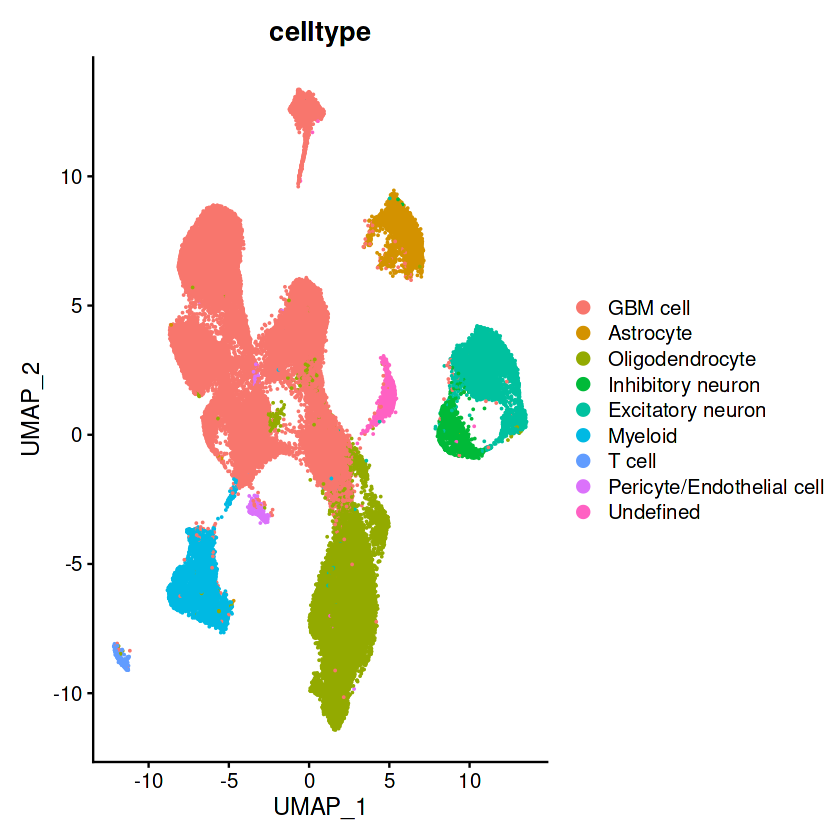

In [6]:
DimPlot(obj, group.by = "celltype")

In [5]:
obj <- obj %>% NormalizeData(verbose = FALSE) %>% FindVariableFeatures(verbose = FALSE) %>% ScaleData(verbose = FALSE) %>% RunMCA(verbose = FALSE) %>% RunPCA(verbose = FALSE)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 26.5 GiB”
Computing Fuzzy Matrix



128.506 sec elapsed


Computing SVD



242.373 sec elapsed


Computing Coordinates



52.033 sec elapsed


Warning message:
“Number of dimensions changing from 30 to 50”


In [6]:
obj <- RunHarmony(obj, group.by.vars = "donor_id", verbose = FALSE)

In [7]:
obj <- obj %>% RunUMAP(reduction = "harmony", dims = 1:30, verbose = FALSE) %>% FindNeighbors(reduction = "harmony", dims = 1:30, verbose = FALSE) %>% FindClusters(verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [8]:
signatures <- as.data.frame(readxl::read_excel(here('markers/gbmap.xlsx'), sheet = "S2"))
signatures <- signatures[-1:-2,] %>% `rownames<-` (NULL)
signatures.list <- list()
for(i in 1:length(colnames(signatures))){
  tmp <- list(na.omit(signatures[[i]]))
  signatures.list <- append(signatures.list, tmp)
}
names(signatures.list) <- colnames(signatures)

In [9]:
HGT_gbm_gs <- RunCellHGT(obj, pathways = signatures.list, dims = 1:50, n.features = 200)
gs_prediction <- rownames(HGT_gbm_gs)[apply(HGT_gbm_gs, 2, which.max)]
gs_prediction_signif <- ifelse(apply(HGT_gbm_gs, 2, max)>2, yes = gs_prediction, "unassigned")
obj$gs_prediction_main <- gs_prediction_signif


calculating distance


ranking genes

19 pathways kept for hypergeometric test out of 19, 0 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test




In [10]:
saveRDS(obj, here('output/wang2024_2.rds'))

# 3. Copykat & SingleR & Azimuth & Marker gene annotation

In [ ]:
ref <- readRDS(here("data/gbmap/azimuth_core_GBmap.rds"))
obj <- RunAzimuth(obj, reference = ref, annotation.levels = c('annotation_level_3', 'annotation_level_4'))

An object of class Seurat 
5000 features across 338564 samples within 1 assay 
Active assay: RNA (5000 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [ ]:
copykat <- read_csv(here('output/copykat_tnl.csv')) |> select(-1) %>% column_to_rownames(var = names(.)[1])

New names:
• `` -> `...1`
Rows: 77064 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): ...1, cell.names, copykat.pred

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
obj <- AddMetaData(obj, copykat, col.name = "copykat")

In [ ]:
names(obj[[]])

[1] "orig.ident"         "nCount_RNA"         "nFeature_RNA"       "percent.MT"         "RNA_snn_res.0.8"   
 [6] "seurat_clusters"    "RNA_res.0.8"        "DF.individual"      "DF.pANN.individual" "author"            
[11] "donor_id"           "method"             "assay"              "gs_prediction_main" "copykat"

In [ ]:

FindClusters(obj, resolution = 1.0)

ERROR: Error: Cannot find Leiden algorithm, please install through pip (e.g. pip install leidenalg).


In [ ]:
ref <- HumanPrimaryCellAtlasData()

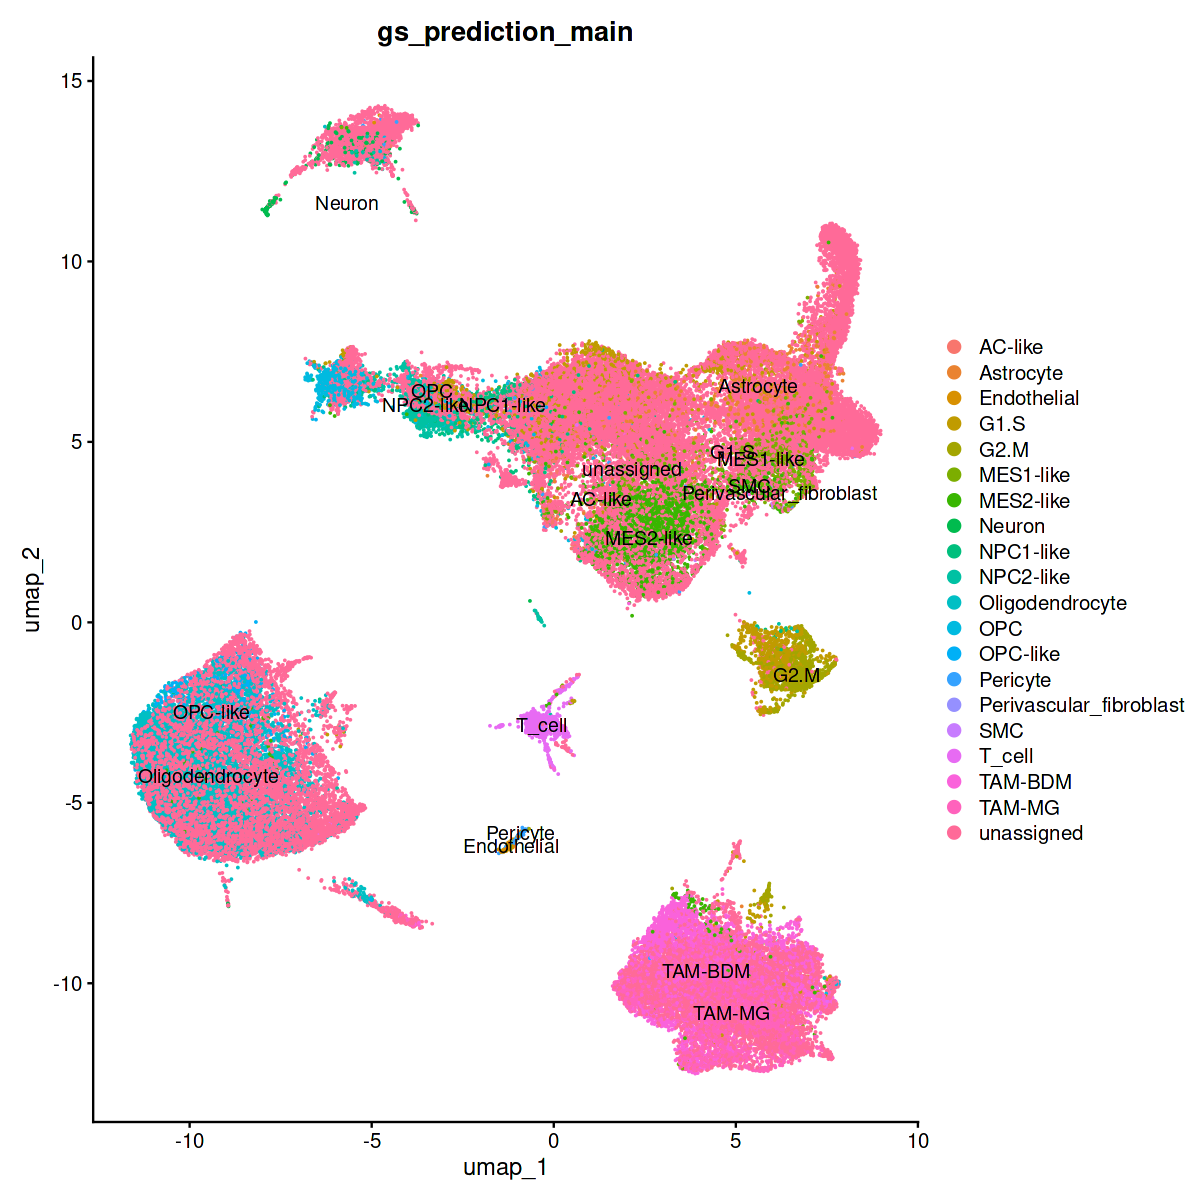

In [ ]:
options(repr.plot.height = 10, repr.plot.width = 10)
DimPlot(obj, group.by = "gs_prediction_main", label = TRUE)

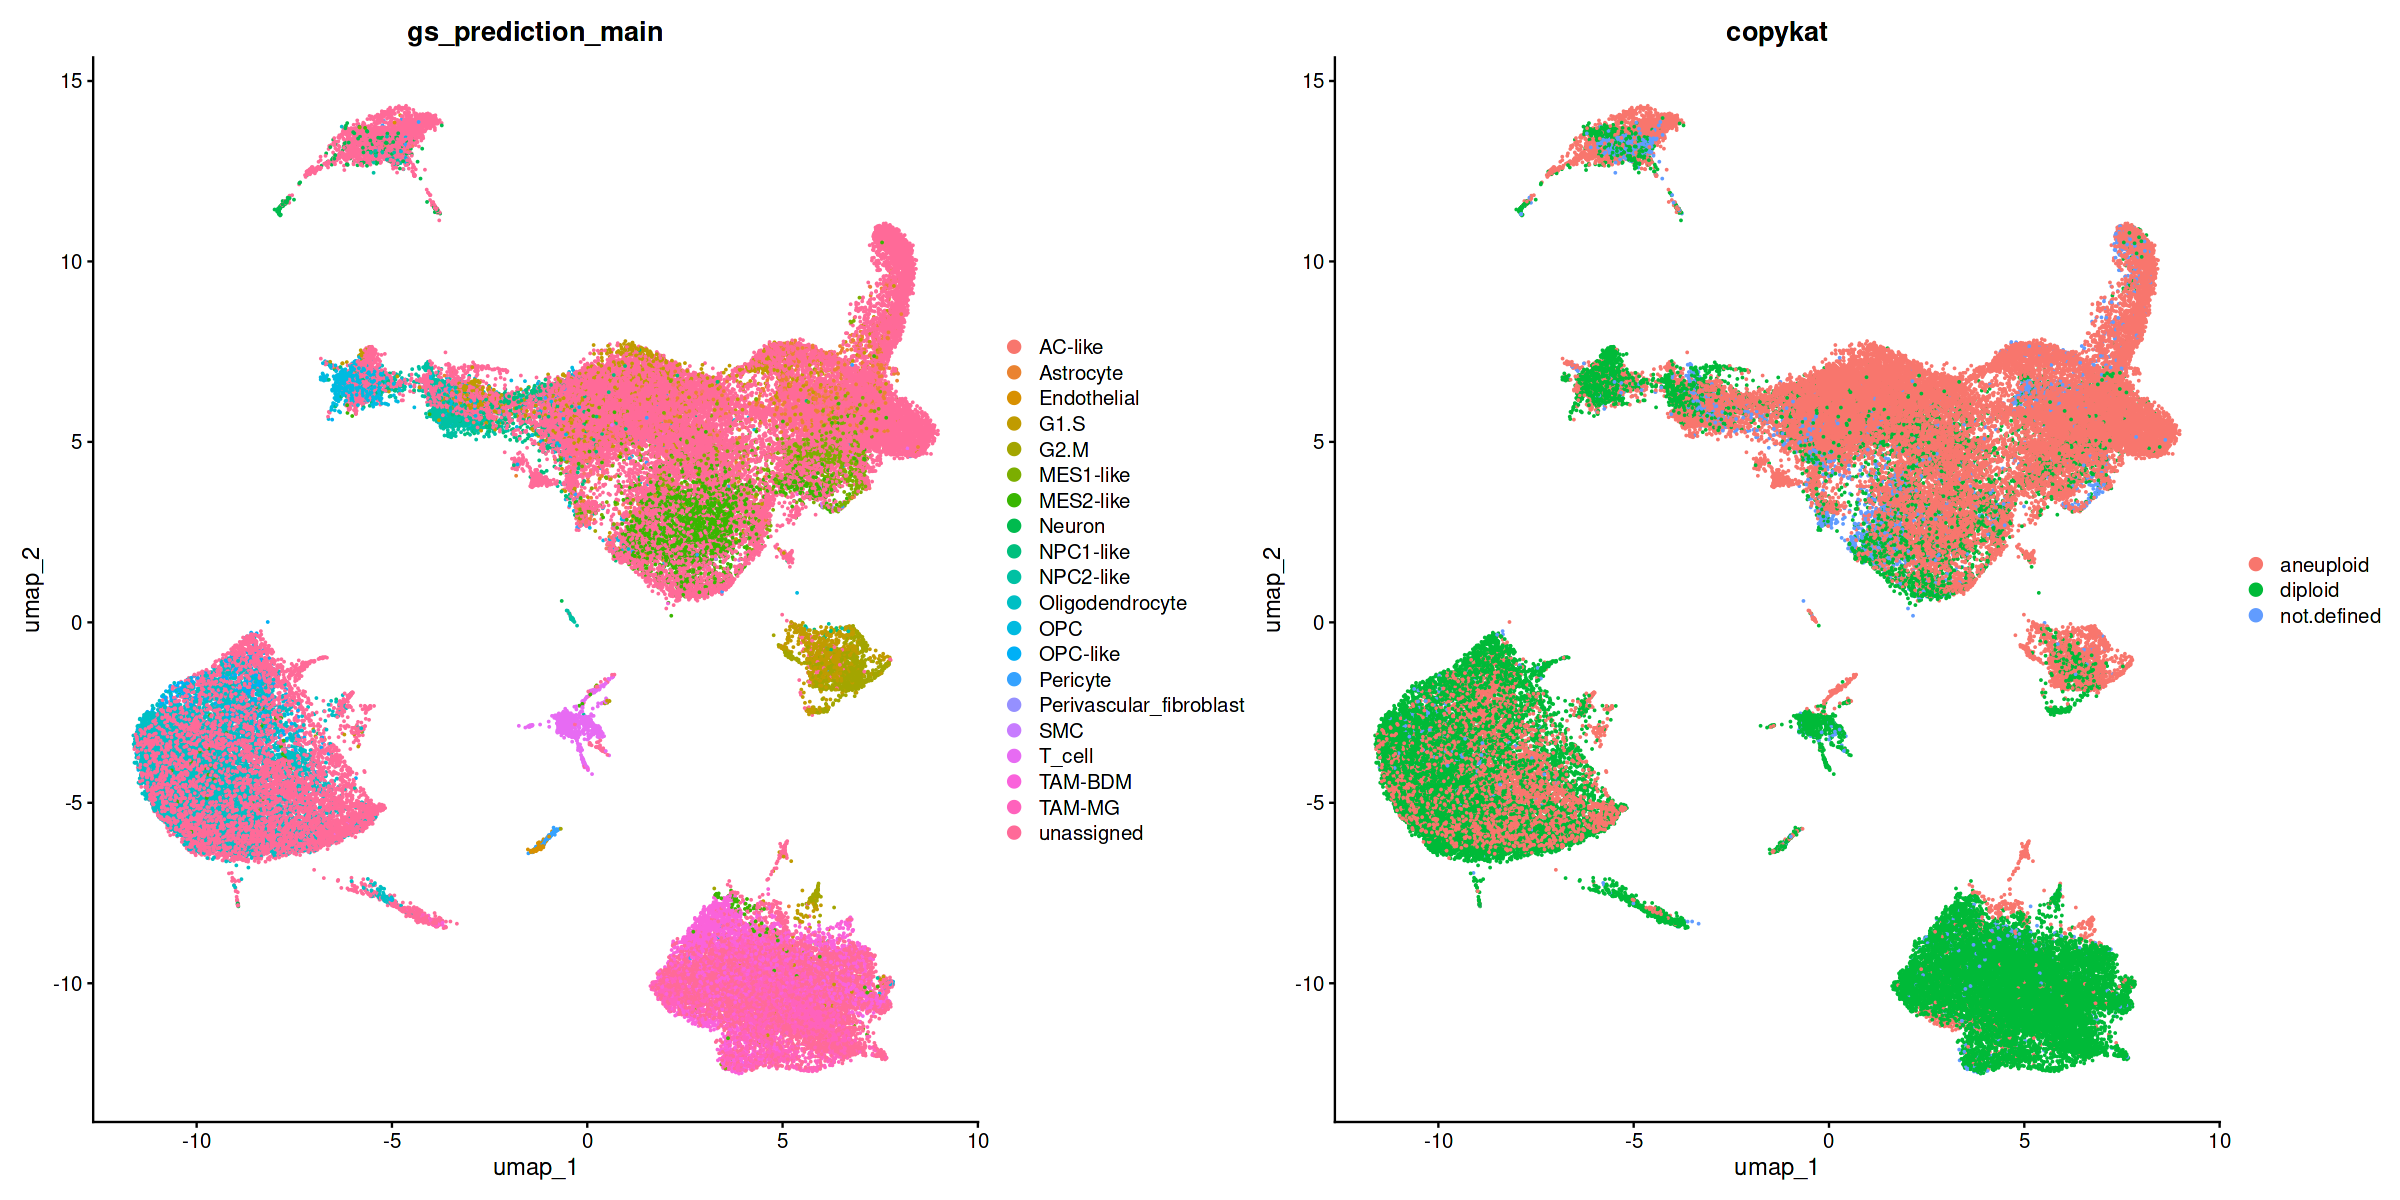

In [ ]:
options(repr.plot.height = 10, repr.plot.width = 20)
DimPlot(obj, group.by = c("gs_prediction_main", "copykat"))

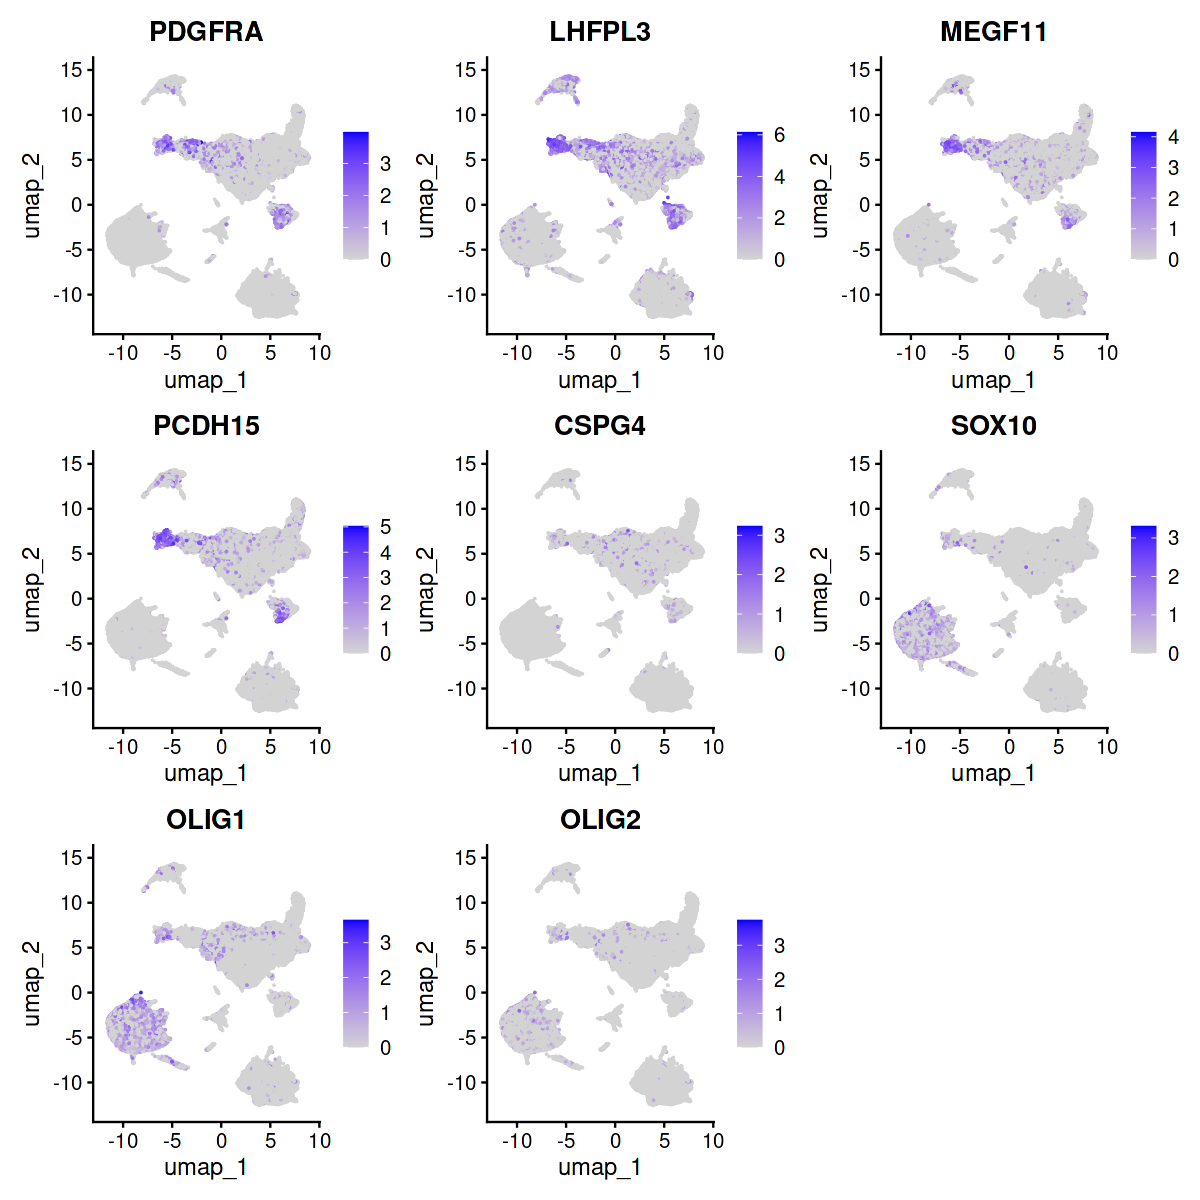

In [ ]:
FeaturePlot(obj, c("PDGFRA", "LHFPL3", "MEGF11", "PCDH15", "CSPG4", "SOX10", "OLIG1", "OLIG2"))

In [ ]:
markers <- c('PTPRZ1', 'CD44', 'CD24', # malignant cells
             'MBP', 'MOBP', 'PLP1',# oligodendrocytes
             "PDGFRA", "LHFPL3", "MEGF11", "PCDH15", "CSPG4", "SOX10", "OLIG1", "OLIG2" # OPC
             'GFAP', 'AQP4', # astrocytes
             'SYT1', # neurons
             'PTPRC', #immune cells
             'ITGA4', 'CD14', 'TGFBI','CD163', # BDM-like
             'P2RY12', 'CX3CR1', # MG-like
             'CD96', 'CD8A', 'IL7R', # T cells
             'VWF','FLT1', # endothelial 
             'DLC1', 'PDGFRB', 'PRKG1' # pericytes
            )